<a href="https://colab.research.google.com/github/monanjo123/dog-cat-classifier/blob/master/cat_vs_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /drive


In [2]:
%ls /drive/

'My Drive'/


In [0]:
# imports
import keras
import os
import zipfile
import cv2
import numpy as np
import shutil
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from google.colab.patches import cv2_imshow


In [0]:
# unzip dataset zip file
local_zip = '/drive/My Drive/Machine Learning/datasets/cat_vs_dogs_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset")
zip_ref.close()

In [6]:
# get filenames
path = '/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset/datasets/catsvsdogs/images'

file_names = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

print(str(len(file_names)) + ' images loaded')

3002 images loaded


In [0]:
# create train and test dataset
def make_dir(directory):
  if os.path.exists(directory):
      shutil.rmtree(directory)
  os.makedirs(directory)

validation_data_dir = '/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset/validation'
train_data_dir = '/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset/train'

cat_train_dir = train_data_dir + '/cat'
dog_train_dir = train_data_dir + '/dog'
cat_validation_dir = validation_data_dir + '/cat'
dog_validation_dir = validation_data_dir + '/dog'

directories = [validation_data_dir , train_data_dir, cat_train_dir, dog_train_dir, cat_validation_dir, dog_validation_dir]

In [0]:
# create directories
for directory in directories:
  make_dir(directory)

# Preprocess Data


1.   Resize Image
2.   Create Validation Data
3.   Create Training Data



In [0]:
# create validation and train data
# 1000 train , 500 validation

img_size = (150, 150)
train_image_data = []
train_image_label = []
validation_image_data = []
validation_image_label = []
train_sample_size = 1000
validation_sample_size = 500
dog_count = 0
cat_count = 0


src_path = '/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset/datasets/catsvsdogs/images/'
for i,file in enumerate(file_names):
  # read image
  img = cv2.imread(src_path+file)
  img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
  if file_names[i][0] == 'd':
    if dog_count < train_sample_size:
      cv2.imwrite(dog_train_dir + '/' + file, img)
      train_image_data.append(img)
      train_image_label.append(1)
    else:
      cv2.imwrite(dog_validation_dir + '/' + file, img)
      validation_image_data.append(img)
      validation_image_label.append(1)
    dog_count += 1
  elif file_names[i][0] == 'c':
    if cat_count < train_sample_size:
      cv2.imwrite(cat_train_dir + '/' + file, img)
      train_image_data.append(img)
      train_image_label.append(0)
    else:
      cv2.imwrite(cat_validation_dir + '/' + file, img)
      validation_image_data.append(img)
      validation_image_label.append(0)
    cat_count += 1 
    
  if cat_count == train_sample_size + validation_sample_size and dog_count == train_sample_size + validation_sample_size:
    break

#   print(i, file)
  



In [13]:
# check number of data

print('total training cat images:', len(os.listdir(cat_train_dir)))
print('total training dog images:', len(os.listdir(dog_train_dir)))
print('total validation cat images:', len(os.listdir(cat_validation_dir)))
print('total validation dog images:', len(os.listdir(dog_validation_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 501
total validation dog images: 501


In [0]:
# Using numpy's savez function to store our loaded data as NPZ files

dataset_path = '/drive/My Drive/Machine Learning/datasets/cat_vs_dog_dataset'
np.savez('{}/training_data.npz'.format(dataset_path), np.array(train_image_data))
np.savez('{}/training_label.npz'.format(dataset_path), np.array(train_image_label))
np.savez('{}/validation_data.npz'.format(dataset_path), np.array(validation_image_data))
np.savez('{}/validation_label.npz'.format(dataset_path), np.array(validation_image_label))

In [44]:
def load_data(dataset_path):
  train_data = np.load('{}/training_data.npz'.format(dataset_path))['arr_0']
  train_label = np.load('{}/training_label.npz'.format(dataset_path))['arr_0']
  validation_data = np.load('{}/validation_data.npz'.format(dataset_path))['arr_0']
  validation_label = np.load('{}/validation_label.npz'.format(dataset_path))['arr_0']
  
  return (train_data, train_label), (validation_data, validation_label)


(x_train, y_train), (x_test, y_test) =  load_data(dataset_path)
print(y_test)
# Reshape label data from (2000,) to (2000,1)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change image type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize data from (0 - 255) to ( 0 - 1 )
x_train /= 255
x_test /= 255
print(y_test.shape)

[1 1 1 ... 0 0 0]
(1002, 1)


In [45]:
# Create CNN Model

batch_size = 16
epochs = 25

img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]
input_shape = (img_rows, img_cols, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_25 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)       

In [46]:
# Train Model
history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    shuffle=True
                   )
model.save('/drive/My Drive/Machine Learning/Models/cat_dog_classifier_v1.h5')

# Evaluate the performance of our trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 2000 samples, validate on 1002 samples
Epoch 1/25
2000/2000 [==============================] - 12s 6ms/step - loss: 0.7378 - acc: 0.5235 - val_loss: 0.6812 - val_acc: 0.6088
Epoch 2/25
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6945 - acc: 0.5775 - val_loss: 0.6546 - val_acc: 0.6577
Epoch 3/25
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6397 - acc: 0.6440 - val_loss: 0.6476 - val_acc: 0.6497
Epoch 4/25
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5978 - acc: 0.6965 - val_loss: 0.5963 - val_acc: 0.6806
Epoch 5/25
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5193 - acc: 0.7530 - val_loss: 0.6748 - val_acc: 0.6766
Epoch 6/25
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4873 - acc: 0.7750 - val_loss: 0.6467 - val_acc: 0.6597
Epoch 7/25
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4292 - acc: 0.8105 - val_loss: 0.5934 - val_acc: 0.7206
Epoch 8/25
20

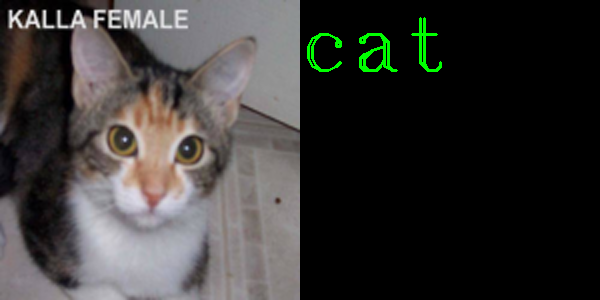

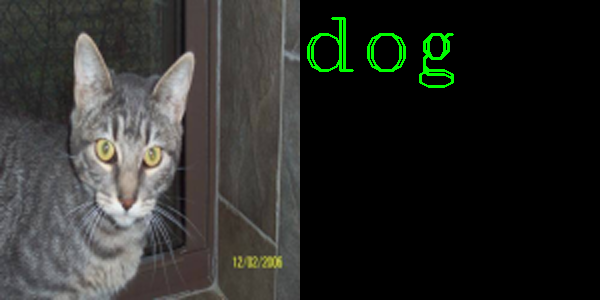

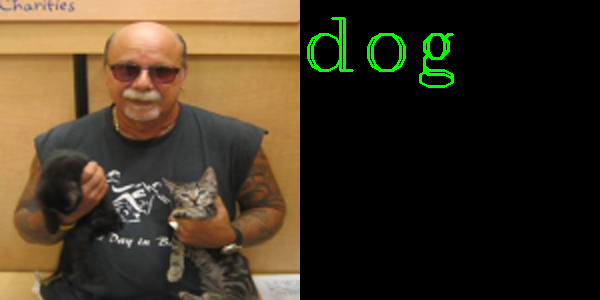

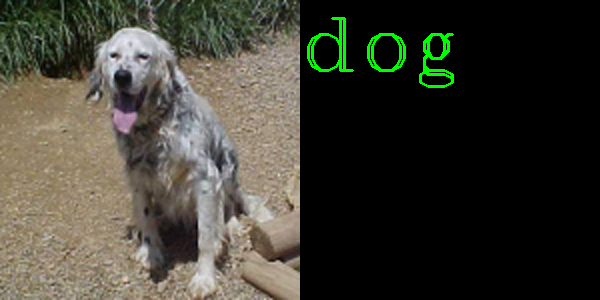

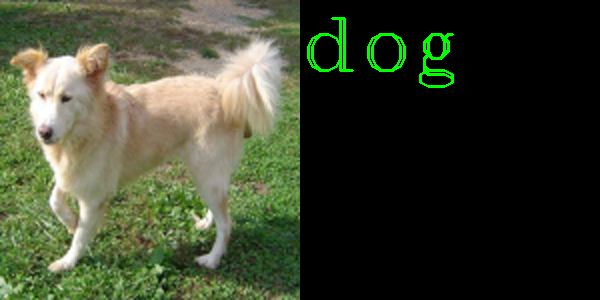

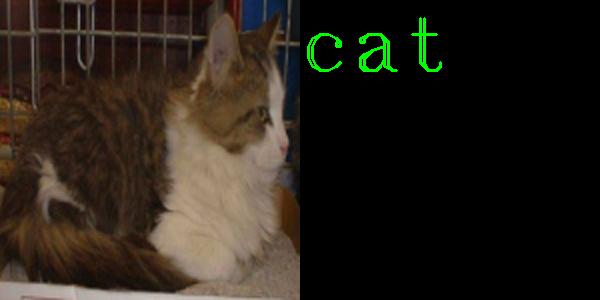

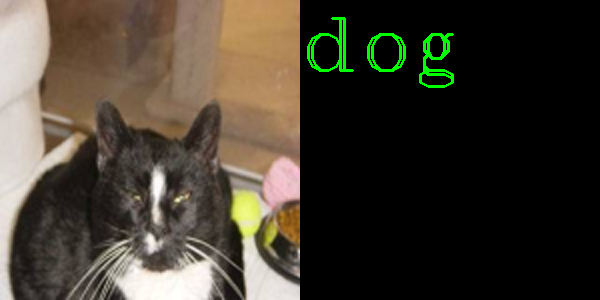

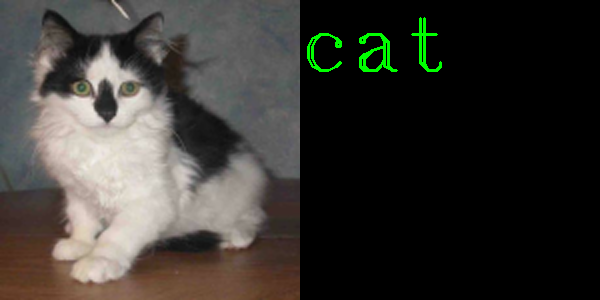

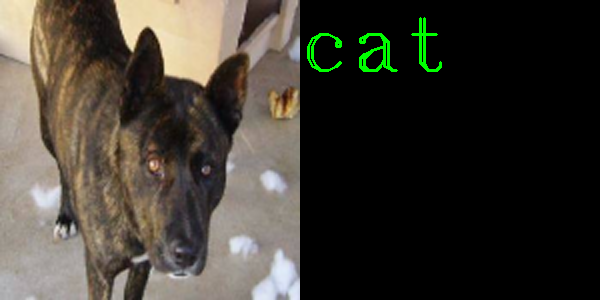

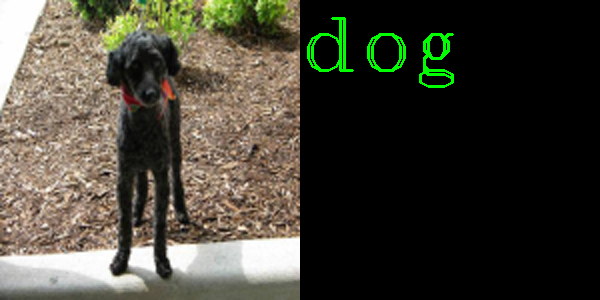

In [57]:
# Test Model

classifier = load_model('/drive/My Drive/Machine Learning/Models/cat_dog_classifier_v1.h5')
(new_x_train, new_y_train), (new_x_test, new_y_test) =  load_data(dataset_path)
def draw_test(name, pred, input_im):
    BLACK = [0,0,0]
    if pred == '[0]':
      pred = 'cat'
    elif pred == '[1]':
      pred = 'dog'
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, input_im.shape[0] ,cv2.BORDER_CONSTANT,value=BLACK)
#     expanded_image = cv2.cvtColor(expanded_image, cv2.COLOR_GRAY2BGR)
    cv2.putText(expanded_image, str(pred), (300, 70) , cv2.FONT_HERSHEY_COMPLEX_SMALL,4, (0,255,0), 2)
    cv2_imshow(expanded_image)


for i in range(0,10):
    rand = np.random.randint(0,len(x_test))
    input_im = new_x_test[rand]

    imageL = cv2.resize(input_im, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
#     cv2_imshow(imageL)
    input_im = input_im.reshape(1,150,150,3)

    ## Get Prediction
    res = str(classifier.predict_classes(input_im, 1, verbose = 0)[0])

    draw_test("Prediction", res, imageL) 
    cv2.waitKey(0)